# Deep Learning - Assignment 3 - Problem 2
### Ali Abbasi - 98105879

# Importing Libraries

In [1]:
import torch
import torchvision
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

import tqdm
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

In [2]:
torch.manual_seed(24)
np.random.seed(24)

# Datasets and Dataloaders

`mean` and `std` are what they have used to normalize Imagenet images in pytorch models.

Reshaping images to `(224, 224)`, results in a much better accuracy since resnet is trained on images of this size. (But of course, the training process will become much more time consuming because of reshaping and performing on larger images)

In [3]:
mean=torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
std=torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
normalize = T.Normalize(
   mean=mean,
   std=std
)
transform = T.Compose([T.ToTensor(), T.Resize(224), normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_size = int(0.2 * len(trainset))
train_size = len(trainset) - val_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

Files already downloaded and verified
Files already downloaded and verified


In [4]:
len(trainset), len(valset), len(testset)

(40000, 10000, 10000)

In [5]:
image_shape = trainset[0][0].shape
input_dim = np.prod(image_shape).item()
num_classes = len(testset.classes)
label_names = testset.classes
image_shape

torch.Size([3, 224, 224])

In [6]:
label_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
train_loader = DataLoader(trainset, 128, shuffle=True)
test_loader = DataLoader(testset, 128, shuffle=True)
val_loader = DataLoader(valset, 128, shuffle=True)

## Visualization

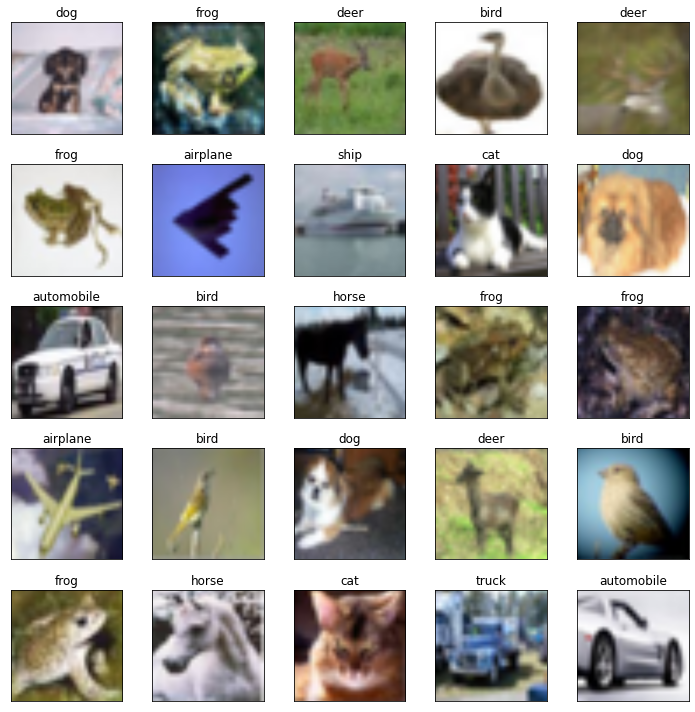

In [8]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
axes = axes.flat
topil = T.ToPILImage()
for ax in axes:
    i = np.random.randint(len(trainset))
    x, y = trainset[i]
    x = x * std + mean
    img = topil(x)
    ax.imshow(img)
    ax.set_title(label_names[y])
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

# Models

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Teacher:

I am using two linear layers for the classifier of the teacher because I want to achieve a better result with finetuning only the classifier head (hence, having a better model to teach the student with).

In [10]:
from torchvision.models.resnet import ResNet50_Weights
def get_teacher():
    teacher = torchvision.models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    teacher.fc = nn.Sequential(nn.Linear(teacher.fc.in_features, 256), nn.Linear(256, num_classes))
    teacher = teacher.to(device)
    return teacher

In [11]:
get_teacher()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Student:

In [12]:
def get_student():
    student = torchvision.models.resnet18(weights=None)
    student.fc = nn.Linear(student.fc.in_features, num_classes)
    student = student.to(device)
    return student

# Training Model

In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [14]:
def one_epoch(models, loader, criterion, optimizer=None, epoch='', train=True, set_name='Train', metrics=None, verbose=True):
    total_loss = 0
    N = len(loader.dataset)
    Y = []
    Y_pred = []
    if len(models) == 2:
        model, teacher = models
        teacher.eval()
    else:
        model = models[0]
        teacher = None
    if train:
        model.train()
    else:
        model.eval()

    with torch.set_grad_enabled(train), tqdm.tqdm(enumerate(loader), total=len(loader), disable=not verbose) as pbar:
        for i, (x, y) in pbar:
            if train:
                optimizer.zero_grad()

            x = x.to(device)
            y = y.to(device)
            p_s = model(x)
            
            if teacher:
                with torch.no_grad():
                    p_t = teacher(x)
                loss = criterion(p_s, p_t, y)
            else:
                loss = criterion(p_s, y)

            if train:
                loss.backward()
                optimizer.step()

            total_loss += loss.item() * len(x)
            pbar.set_description(f'{epoch}: {set_name} Loss: {total_loss / N:.3e}')

            y_pred = p_s.argmax(dim=-1)
            Y.append(y.cpu().numpy())
            Y_pred.append(y_pred.cpu().numpy())

    total_loss /= N

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy_score(Y_pred, Y)
    if verbose:
        print(f'Accuracy of {set_name} set: {acc}')

    result = {'loss': total_loss, 'accuracy': acc}
    if metrics is not None:
        result.update({metric: metric_func(Y, Y_pred) for metric, metric_func in metrics.items()})

    return result

In [15]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def clear_history():
    train_losses.clear()
    val_losses.clear()
    train_accuracies.clear()
    val_accuracies.clear()

In [16]:
def train_model(models, dataloaders, num_epochs, criterion, optimizer, scheduler=None, model_name='pytroch-model', verbose=True):
    train_loader, val_loader = dataloaders
    min_val_loss = np.inf
    for epoch in range(num_epochs):
        result = one_epoch(models, train_loader, criterion, optimizer, epoch, train=True, set_name='Train', verbose=verbose)
        train_loss = result['loss']
        train_acc = result['accuracy']
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_result = one_epoch(models, val_loader, criterion, epoch=epoch, train=False, set_name='Validation', verbose=verbose)
        val_loss = val_result['loss']
        val_acc = val_result['accuracy']
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        if scheduler:
            scheduler.step(val_loss)
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(models[0].state_dict(), f'{model_name}.pt')
        if verbose:
            print('\n', '-' * 60)

    if verbose:
        plt.plot(train_losses, label='train')
        plt.plot(val_losses, label='val')
        plt.title('loss history of training and val sets')
        plt.legend()
        plt.show()

        plt.plot(train_accuracies, label='train')
        plt.plot(val_accuracies, label='val')
        plt.title('Accuracy history of training and val sets')
        plt.legend()
        plt.show()

    models[0].load_state_dict(torch.load(f'{model_name}.pt'))
    return models[0], min_val_loss

### Fine Tuning Teacher

In [ ]:
clear_history()

# freezing all layers except the last one
teacher = get_teacher()
teacher.requires_grad_(False)
teacher.fc.requires_grad_(True)

Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
# Training config
lr = 5e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, teacher.parameters()), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, threshold=0.0001, verbose=True)
# step_scheduler = optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.2, verbose=True)

0: Train Loss: 8.195e-01: 100%|██████████| 157/157 [02:56<00:00,  1.13s/it]


Accuracy of Train set: 0.73175


0: Validation Loss: 6.827e-01: 100%|██████████| 40/40 [00:40<00:00,  1.00s/it]


Accuracy of Validation set: 0.7636

 ------------------------------------------------------------


1: Train Loss: 5.904e-01: 100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


Accuracy of Train set: 0.7938


1: Validation Loss: 5.865e-01: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


Accuracy of Validation set: 0.793

 ------------------------------------------------------------


2: Train Loss: 5.480e-01: 100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


Accuracy of Train set: 0.8093


2: Validation Loss: 5.629e-01: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


Accuracy of Validation set: 0.8002

 ------------------------------------------------------------


3: Train Loss: 5.370e-01: 100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


Accuracy of Train set: 0.812725


3: Validation Loss: 5.518e-01: 100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


Accuracy of Validation set: 0.8069

 ------------------------------------------------------------


4: Train Loss: 5.089e-01: 100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


Accuracy of Train set: 0.821575


4: Validation Loss: 5.444e-01: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


Accuracy of Validation set: 0.8141

 ------------------------------------------------------------


5: Train Loss: 4.997e-01: 100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


Accuracy of Train set: 0.826125


5: Validation Loss: 5.186e-01: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


Accuracy of Validation set: 0.8223

 ------------------------------------------------------------


6: Train Loss: 4.981e-01: 100%|██████████| 157/157 [02:51<00:00,  1.10s/it]


Accuracy of Train set: 0.8249


6: Validation Loss: 5.386e-01: 100%|██████████| 40/40 [00:40<00:00,  1.00s/it]


Accuracy of Validation set: 0.8156

 ------------------------------------------------------------


7: Train Loss: 4.909e-01: 100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


Accuracy of Train set: 0.8292


7: Validation Loss: 5.501e-01: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


Accuracy of Validation set: 0.8092

 ------------------------------------------------------------


8: Train Loss: 4.879e-01: 100%|██████████| 157/157 [02:52<00:00,  1.10s/it]


Accuracy of Train set: 0.8283


8: Validation Loss: 5.311e-01: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


Accuracy of Validation set: 0.8215
Epoch 00009: reducing learning rate of group 0 to 1.0000e-04.

 ------------------------------------------------------------


9: Train Loss: 4.370e-01: 100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


Accuracy of Train set: 0.8474


9: Validation Loss: 4.943e-01: 100%|██████████| 40/40 [00:39<00:00,  1.00it/s]


Accuracy of Validation set: 0.8281

 ------------------------------------------------------------


10: Train Loss: 4.304e-01: 100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


Accuracy of Train set: 0.849725


10: Validation Loss: 4.937e-01: 100%|██████████| 40/40 [00:40<00:00,  1.00s/it]


Accuracy of Validation set: 0.8273

 ------------------------------------------------------------


11: Train Loss: 4.304e-01: 100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


Accuracy of Train set: 0.8495


11: Validation Loss: 5.003e-01: 100%|██████████| 40/40 [00:40<00:00,  1.00s/it]


Accuracy of Validation set: 0.8264

 ------------------------------------------------------------


12: Train Loss: 4.286e-01: 100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


Accuracy of Train set: 0.850725


12: Validation Loss: 4.915e-01: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


Accuracy of Validation set: 0.8289

 ------------------------------------------------------------


13: Train Loss: 4.255e-01: 100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


Accuracy of Train set: 0.85235


13: Validation Loss: 4.947e-01: 100%|██████████| 40/40 [00:40<00:00,  1.00s/it]


Accuracy of Validation set: 0.8276

 ------------------------------------------------------------


14: Train Loss: 4.238e-01: 100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


Accuracy of Train set: 0.8517


14: Validation Loss: 4.981e-01: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


Accuracy of Validation set: 0.8292

 ------------------------------------------------------------


15: Train Loss: 4.210e-01: 100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


Accuracy of Train set: 0.853575


15: Validation Loss: 4.957e-01: 100%|██████████| 40/40 [00:40<00:00,  1.00s/it]


Accuracy of Validation set: 0.8265
Epoch 00016: reducing learning rate of group 0 to 2.0000e-05.

 ------------------------------------------------------------


16: Train Loss: 4.130e-01: 100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


Accuracy of Train set: 0.855


16: Validation Loss: 4.871e-01: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


Accuracy of Validation set: 0.8311

 ------------------------------------------------------------


17: Train Loss: 4.114e-01: 100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


Accuracy of Train set: 0.8578


17: Validation Loss: 4.869e-01: 100%|██████████| 40/40 [00:40<00:00,  1.00s/it]


Accuracy of Validation set: 0.8297

 ------------------------------------------------------------


18: Train Loss: 4.095e-01: 100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


Accuracy of Train set: 0.85865


18: Validation Loss: 4.874e-01: 100%|██████████| 40/40 [00:39<00:00,  1.00it/s]


Accuracy of Validation set: 0.8298

 ------------------------------------------------------------


19: Train Loss: 4.099e-01: 100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


Accuracy of Train set: 0.8582


19: Validation Loss: 4.871e-01: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


Accuracy of Validation set: 0.8299

 ------------------------------------------------------------


20: Train Loss: 4.109e-01: 100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


Accuracy of Train set: 0.85675


20: Validation Loss: 4.853e-01: 100%|██████████| 40/40 [00:39<00:00,  1.00it/s]


Accuracy of Validation set: 0.8316

 ------------------------------------------------------------


21: Train Loss: 4.091e-01: 100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


Accuracy of Train set: 0.85825


21: Validation Loss: 4.875e-01: 100%|██████████| 40/40 [00:40<00:00,  1.01s/it]


Accuracy of Validation set: 0.83

 ------------------------------------------------------------


22: Train Loss: 4.081e-01: 100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


Accuracy of Train set: 0.859075


22: Validation Loss: 4.860e-01: 100%|██████████| 40/40 [00:40<00:00,  1.00s/it]


Accuracy of Validation set: 0.8312

 ------------------------------------------------------------


23: Train Loss: 4.077e-01: 100%|██████████| 157/157 [02:50<00:00,  1.09s/it]


Accuracy of Train set: 0.857925


23: Validation Loss: 4.871e-01: 100%|██████████| 40/40 [00:40<00:00,  1.00s/it]


Accuracy of Validation set: 0.8295
Epoch 00024: reducing learning rate of group 0 to 4.0000e-06.

 ------------------------------------------------------------


24: Train Loss: 4.065e-01: 100%|██████████| 157/157 [02:51<00:00,  1.09s/it]


Accuracy of Train set: 0.858525


24: Validation Loss: 4.855e-01: 100%|██████████| 40/40 [00:40<00:00,  1.00s/it]


Accuracy of Validation set: 0.8308

 ------------------------------------------------------------


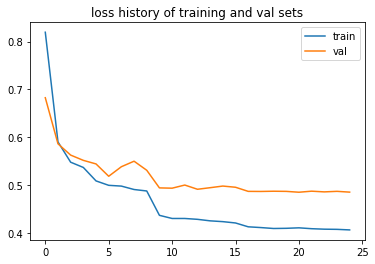

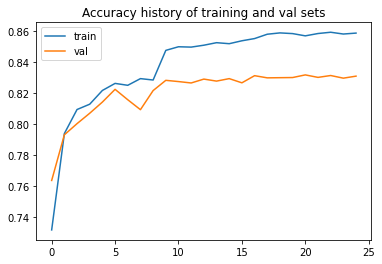

In [ ]:
teacher, min_val_loss = train_model([teacher], [train_loader, val_loader], 25, criterion, optimizer, scheduler=scheduler)

### Teacher's Training Results

In [17]:
average_policy = 'macro'
metrics = {'accuracy': accuracy_score, 'precision': lambda y1, y2: precision_score(y1, y2, average=average_policy),
           'recall': lambda y1, y2: recall_score(y1, y2, average=average_policy),
           'f1': lambda y1, y2: f1_score(y1, y2, average=average_policy),
           'confusion_matrix': confusion_matrix}

: Test Loss: 4.924e-01: 100%|██████████| 40/40 [00:47<00:00,  1.18s/it]

Accuracy of Test set: 0.8309


{'loss': 0.49242081003189087,
 'accuracy': 0.8309,
 'precision': 0.8313070993203551,
 'recall': 0.8309000000000001,
 'f1': 0.8310670623757644}

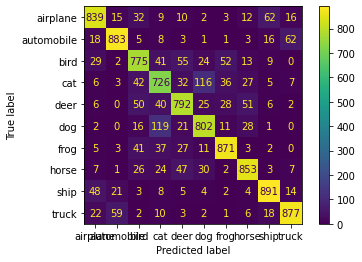

In [ ]:
test_results = one_epoch([teacher], test_loader, criterion, train=False, set_name='Test', metrics=metrics)
disp = ConfusionMatrixDisplay(test_results.pop('confusion_matrix'), display_labels=label_names)
disp.plot()
test_results

: Validation Loss: 4.853e-01: 100%|██████████| 40/40 [00:40<00:00,  1.00s/it]

Accuracy of Validation set: 0.8316


{'loss': 0.4852665279388428,
 'accuracy': 0.8316,
 'precision': 0.8314415804268049,
 'recall': 0.83128963093008,
 'f1': 0.831317414446821}

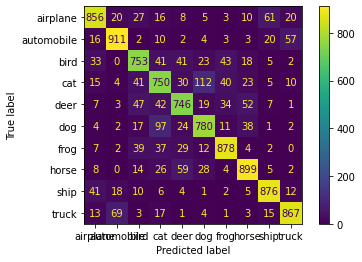

In [ ]:
val_results = one_epoch([teacher], val_loader, criterion, train=False, set_name='Validation', metrics=metrics)
disp = ConfusionMatrixDisplay(val_results.pop('confusion_matrix'), display_labels=label_names)
disp.plot()
val_results

: Train Loss: 3.987e-01: 100%|██████████| 157/157 [02:41<00:00,  1.03s/it]

Accuracy of Train set: 0.860225


{'loss': 0.39871922709941865,
 'accuracy': 0.860225,
 'precision': 0.860533374165743,
 'recall': 0.8602917488074345,
 'f1': 0.8603330525108849}

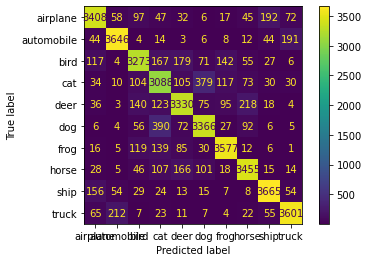

In [ ]:
train_results = one_epoch([teacher], train_loader, criterion, train=False, set_name='Train', metrics=metrics)
disp = ConfusionMatrixDisplay(train_results.pop('confusion_matrix'), display_labels=label_names)
disp.plot()
train_results

In [ ]:
torch.save(teacher.state_dict(), 'teacher.pt')

### Training Student

In [ ]:
class DistillationLoss(nn.Module):
    def __init__(self, alpha=0.9, T=2):
        super().__init__()
        self.alpha = alpha
        self.T = T
        self.kl_div = nn.KLDivLoss(log_target=True, reduction="batchmean")
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, p_s, p_t, y):
        teacher_loss = self.kl_div(F.log_softmax(p_s / self.T, dim=-1), F.log_softmax(p_t / self.T, dim=-1)) 
        student_loss = self.cross_entropy(p_s, y)
        return (1-self.alpha) * student_loss + self.alpha * self.T * self.T * teacher_loss

Hyperparameter Tuning:

In [ ]:
teacher.requires_grad_(False)

best_val_loss = np.inf
best_alpha = 0
best_T = 0
lr = 5e-4

0: Train Loss: 3.174e+00: 100%|██████████| 157/157 [04:35<00:00,  1.75s/it]


Accuracy of Train set: 0.499075


0: Validation Loss: 2.982e+00: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Accuracy of Validation set: 0.5267

 ------------------------------------------------------------


1: Train Loss: 1.963e+00: 100%|██████████| 157/157 [04:36<00:00,  1.76s/it]


Accuracy of Train set: 0.67965


1: Validation Loss: 2.406e+00: 100%|██████████| 40/40 [00:50<00:00,  1.25s/it]


Accuracy of Validation set: 0.6201

 ------------------------------------------------------------


2: Train Loss: 1.598e+00: 100%|██████████| 157/157 [04:36<00:00,  1.76s/it]


Accuracy of Train set: 0.7532


2: Validation Loss: 1.930e+00: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Accuracy of Validation set: 0.695

 ------------------------------------------------------------


3: Train Loss: 1.356e+00: 100%|██████████| 157/157 [04:36<00:00,  1.76s/it]


Accuracy of Train set: 0.800775


3: Validation Loss: 2.095e+00: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Accuracy of Validation set: 0.7128

 ------------------------------------------------------------


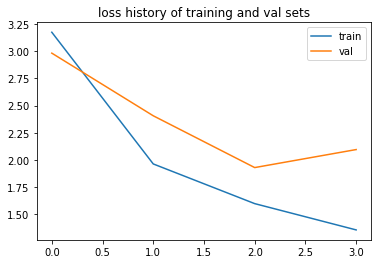

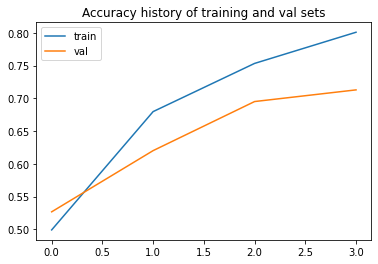

(0) alpha=0.67, T=4.78, val_loss=1.9297


0: Train Loss: 3.854e+00: 100%|██████████| 157/157 [04:36<00:00,  1.76s/it]


Accuracy of Train set: 0.498475


0: Validation Loss: 3.749e+00: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Accuracy of Validation set: 0.5246

 ------------------------------------------------------------


1: Train Loss: 2.413e+00: 100%|██████████| 157/157 [04:36<00:00,  1.76s/it]


Accuracy of Train set: 0.6733


1: Validation Loss: 2.987e+00: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Accuracy of Validation set: 0.6165

 ------------------------------------------------------------


2: Train Loss: 1.974e+00: 100%|██████████| 157/157 [04:36<00:00,  1.76s/it]


Accuracy of Train set: 0.736475


2: Validation Loss: 2.543e+00: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Accuracy of Validation set: 0.6862

 ------------------------------------------------------------


3: Train Loss: 1.720e+00: 100%|██████████| 157/157 [04:36<00:00,  1.76s/it]


Accuracy of Train set: 0.77695


3: Validation Loss: 2.013e+00: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Accuracy of Validation set: 0.757

 ------------------------------------------------------------


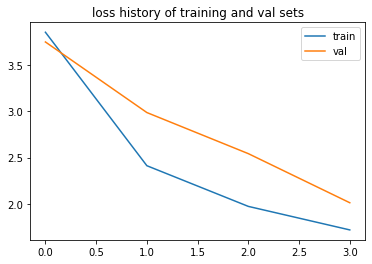

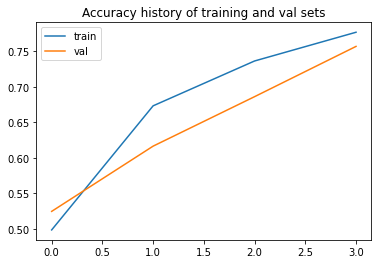

(1) alpha=0.96, T=4.81, val_loss=2.0130


0: Train Loss: 1.566e+00: 100%|██████████| 157/157 [04:35<00:00,  1.76s/it]


Accuracy of Train set: 0.525125


0: Validation Loss: 1.343e+00: 100%|██████████| 40/40 [00:50<00:00,  1.25s/it]


Accuracy of Validation set: 0.5989

 ------------------------------------------------------------


1: Train Loss: 9.733e-01: 100%|██████████| 157/157 [04:36<00:00,  1.76s/it]


Accuracy of Train set: 0.693175


1: Validation Loss: 1.042e+00: 100%|██████████| 40/40 [00:50<00:00,  1.25s/it]


Accuracy of Validation set: 0.6862

 ------------------------------------------------------------


2: Train Loss: 7.510e-01: 100%|██████████| 157/157 [04:36<00:00,  1.76s/it]


Accuracy of Train set: 0.767125


2: Validation Loss: 9.428e-01: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Accuracy of Validation set: 0.7274

 ------------------------------------------------------------


3: Train Loss: 6.193e-01: 100%|██████████| 157/157 [04:37<00:00,  1.77s/it]


Accuracy of Train set: 0.80855


3: Validation Loss: 8.324e-01: 100%|██████████| 40/40 [00:50<00:00,  1.25s/it]


Accuracy of Validation set: 0.7619

 ------------------------------------------------------------


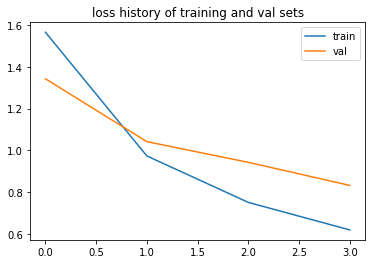

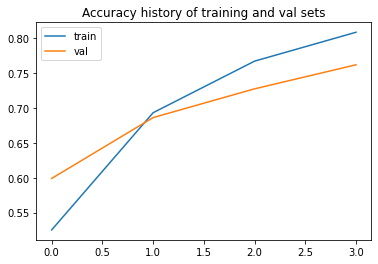

(2) alpha=0.97, T=1.44, val_loss=0.8324


0: Train Loss: 2.272e+00: 100%|██████████| 157/157 [04:37<00:00,  1.76s/it]


Accuracy of Train set: 0.516175


0: Validation Loss: 2.024e+00: 100%|██████████| 40/40 [00:50<00:00,  1.25s/it]


Accuracy of Validation set: 0.5836

 ------------------------------------------------------------


1: Train Loss: 1.151e+00:  81%|████████  | 127/157 [03:44<00:53,  1.77s/it]


KeyboardInterrupt: ignored

In [ ]:
for i in range(5):
    alpha = np.random.uniform(0.5, 1)
    T = np.random.uniform(1, 5)
    

    clear_history()
    student = get_student()
    criterion = DistillationLoss(alpha, T)
    optimizer = optim.Adam(student.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=1, threshold=0.0001, verbose=True)
    student, val_loss = train_model([student, teacher], [train_loader, val_loader], 4, criterion, optimizer, verbose=True, scheduler=scheduler)
    print(f'({i}) alpha={alpha:.2f}, T={T:.2f}, val_loss={val_loss:.4f}')
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_alpha = alpha
        best_T = T

print(f'Best parameters: alpha={best_alpha:.2f}, T={best_T:.2f}, val_loss={best_val_loss:.4f},')

Interrupted hyperparameter tuning since it takes a long time and I am running out of gpu! But found some good $\alpha$ and T values.

Training Student:

In [ ]:
best_alpha, best_T

(0.97, 1.44)

0: Train Loss: 1.583e+00: 100%|██████████| 157/157 [04:33<00:00,  1.74s/it]


Accuracy of Train set: 0.520225


0: Validation Loss: 1.424e+00: 100%|██████████| 40/40 [00:49<00:00,  1.24s/it]


Accuracy of Validation set: 0.5883

 ------------------------------------------------------------


1: Train Loss: 9.733e-01: 100%|██████████| 157/157 [04:36<00:00,  1.76s/it]


Accuracy of Train set: 0.68925


1: Validation Loss: 1.022e+00: 100%|██████████| 40/40 [00:49<00:00,  1.24s/it]


Accuracy of Validation set: 0.6968

 ------------------------------------------------------------


2: Train Loss: 7.595e-01: 100%|██████████| 157/157 [04:36<00:00,  1.76s/it]


Accuracy of Train set: 0.762325


2: Validation Loss: 9.539e-01: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Accuracy of Validation set: 0.7275

 ------------------------------------------------------------


3: Train Loss: 6.319e-01: 100%|██████████| 157/157 [04:37<00:00,  1.77s/it]


Accuracy of Train set: 0.804075


3: Validation Loss: 8.839e-01: 100%|██████████| 40/40 [00:50<00:00,  1.25s/it]


Accuracy of Validation set: 0.7501

 ------------------------------------------------------------


4: Train Loss: 5.409e-01: 100%|██████████| 157/157 [04:36<00:00,  1.76s/it]


Accuracy of Train set: 0.83215


4: Validation Loss: 7.751e-01: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Accuracy of Validation set: 0.7803

 ------------------------------------------------------------


5: Train Loss: 4.534e-01: 100%|██████████| 157/157 [04:35<00:00,  1.76s/it]


Accuracy of Train set: 0.850325


5: Validation Loss: 8.367e-01: 100%|██████████| 40/40 [00:50<00:00,  1.25s/it]


Accuracy of Validation set: 0.7651

 ------------------------------------------------------------


6: Train Loss: 3.764e-01: 100%|██████████| 157/157 [04:35<00:00,  1.76s/it]


Accuracy of Train set: 0.860925


6: Validation Loss: 8.469e-01: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Accuracy of Validation set: 0.759

 ------------------------------------------------------------


7: Train Loss: 3.129e-01: 100%|██████████| 157/157 [04:35<00:00,  1.75s/it]


Accuracy of Train set: 0.8623


7: Validation Loss: 8.116e-01: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Accuracy of Validation set: 0.7813

 ------------------------------------------------------------


8: Train Loss: 2.615e-01: 100%|██████████| 157/157 [04:35<00:00,  1.76s/it]


Accuracy of Train set: 0.8651


8: Validation Loss: 8.192e-01: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Accuracy of Validation set: 0.774

 ------------------------------------------------------------


9: Train Loss: 2.231e-01: 100%|██████████| 157/157 [04:35<00:00,  1.75s/it]


Accuracy of Train set: 0.8627


9: Validation Loss: 8.490e-01: 100%|██████████| 40/40 [00:49<00:00,  1.25s/it]


Accuracy of Validation set: 0.7677

 ------------------------------------------------------------


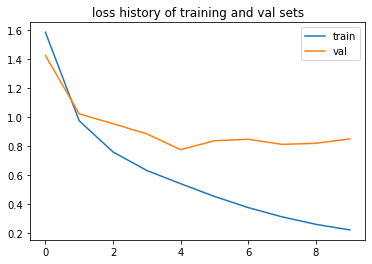

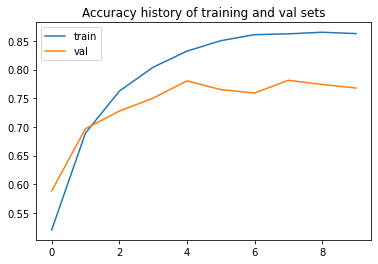

In [ ]:
clear_history()
student = get_student()
criterion = DistillationLoss(best_alpha, best_T)
optimizer = optim.Adam(student.parameters(), lr=lr)
student, min_val_loss = train_model([student, teacher], [train_loader, val_loader], 10, criterion, optimizer)

### Student's Training Results

In [ ]:
criterion = nn.CrossEntropyLoss()

: Test Loss: 6.477e-01: 100%|██████████| 40/40 [00:22<00:00,  1.80it/s]

Accuracy of Test set: 0.7771


{'loss': 0.6476888027191162,
 'accuracy': 0.7771,
 'precision': 0.7896045107552719,
 'recall': 0.7771,
 'f1': 0.7793920956597956}

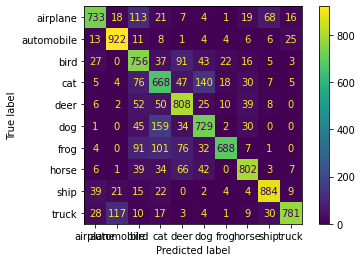

In [ ]:
test_results = one_epoch([student], test_loader, criterion, train=False, set_name='Test', metrics=metrics)
disp = ConfusionMatrixDisplay(test_results.pop('confusion_matrix'), display_labels=label_names)
disp.plot()
test_results

: Validation Loss: 6.326e-01: 100%|██████████| 40/40 [00:22<00:00,  1.79it/s]

Accuracy of Validation set: 0.7803


{'loss': 0.6325539580345154,
 'accuracy': 0.7803,
 'precision': 0.7922057130426239,
 'recall': 0.7804585727879783,
 'f1': 0.7818933193217148}

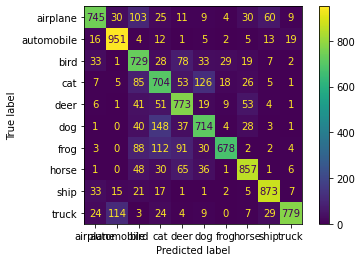

In [ ]:
val_results = one_epoch([student], val_loader, criterion, train=False, set_name='Validation', metrics=metrics)
disp = ConfusionMatrixDisplay(val_results.pop('confusion_matrix'), display_labels=label_names)
disp.plot()
val_results

: Train Loss: 5.225e-01: 100%|██████████| 157/157 [01:29<00:00,  1.76it/s]


Accuracy of Train set: 0.825025


{'loss': 0.5224988565444947,
 'accuracy': 0.825025,
 'precision': 0.834270623006843,
 'recall': 0.8249788809686891,
 'f1': 0.8267333895609749}

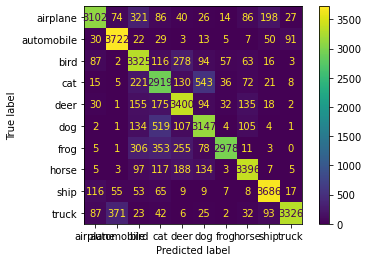

In [ ]:
train_results = one_epoch([student], train_loader, criterion, train=False, set_name='Train', metrics=metrics)
disp = ConfusionMatrixDisplay(train_results.pop('confusion_matrix'), display_labels=label_names)
disp.plot()
train_results

### Training Student from Scratch

0: Train Loss: 1.341e+00: 100%|██████████| 157/157 [02:41<00:00,  1.03s/it]


Accuracy of Train set: 0.5116


0: Validation Loss: 1.237e+00: 100%|██████████| 40/40 [00:22<00:00,  1.80it/s]


Accuracy of Validation set: 0.5545

 ------------------------------------------------------------


1: Train Loss: 8.806e-01: 100%|██████████| 157/157 [02:42<00:00,  1.03s/it]


Accuracy of Train set: 0.68835


1: Validation Loss: 1.031e+00: 100%|██████████| 40/40 [00:22<00:00,  1.81it/s]


Accuracy of Validation set: 0.6405

 ------------------------------------------------------------


2: Train Loss: 6.519e-01: 100%|██████████| 157/157 [02:42<00:00,  1.03s/it]


Accuracy of Train set: 0.771925


2: Validation Loss: 9.341e-01: 100%|██████████| 40/40 [00:22<00:00,  1.79it/s]


Accuracy of Validation set: 0.6962

 ------------------------------------------------------------


3: Train Loss: 4.947e-01: 100%|██████████| 157/157 [02:42<00:00,  1.04s/it]


Accuracy of Train set: 0.8277


3: Validation Loss: 6.438e-01: 100%|██████████| 40/40 [00:22<00:00,  1.79it/s]


Accuracy of Validation set: 0.7741

 ------------------------------------------------------------


4: Train Loss: 3.816e-01: 100%|██████████| 157/157 [02:44<00:00,  1.05s/it]


Accuracy of Train set: 0.867225


4: Validation Loss: 1.022e+00: 100%|██████████| 40/40 [00:22<00:00,  1.80it/s]


Accuracy of Validation set: 0.6686

 ------------------------------------------------------------


5: Train Loss: 2.631e-01: 100%|██████████| 157/157 [02:43<00:00,  1.04s/it]


Accuracy of Train set: 0.9108


5: Validation Loss: 9.327e-01: 100%|██████████| 40/40 [00:22<00:00,  1.79it/s]


Accuracy of Validation set: 0.7238
Epoch 00006: reducing learning rate of group 0 to 1.0000e-04.

 ------------------------------------------------------------


6: Train Loss: 9.242e-02: 100%|██████████| 157/157 [02:44<00:00,  1.05s/it]


Accuracy of Train set: 0.97715


6: Validation Loss: 4.739e-01: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s]


Accuracy of Validation set: 0.8489

 ------------------------------------------------------------


7: Train Loss: 3.511e-02: 100%|██████████| 157/157 [02:44<00:00,  1.05s/it]


Accuracy of Train set: 0.996125


7: Validation Loss: 5.027e-01: 100%|██████████| 40/40 [00:22<00:00,  1.79it/s]


Accuracy of Validation set: 0.8461

 ------------------------------------------------------------


8: Train Loss: 1.840e-02: 100%|██████████| 157/157 [02:44<00:00,  1.05s/it]


Accuracy of Train set: 0.9994


8: Validation Loss: 4.987e-01: 100%|██████████| 40/40 [00:22<00:00,  1.80it/s]


Accuracy of Validation set: 0.8477
Epoch 00009: reducing learning rate of group 0 to 2.0000e-05.

 ------------------------------------------------------------


9: Train Loss: 1.134e-02: 100%|██████████| 157/157 [02:43<00:00,  1.04s/it]


Accuracy of Train set: 0.9999


9: Validation Loss: 4.817e-01: 100%|██████████| 40/40 [00:22<00:00,  1.78it/s]


Accuracy of Validation set: 0.8552

 ------------------------------------------------------------


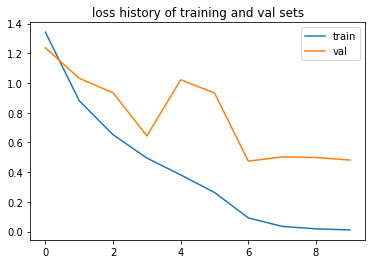

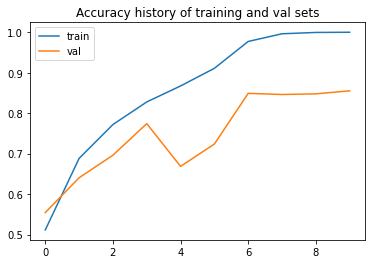

In [ ]:
clear_history()
student = get_student()
criterion = nn.CrossEntropyLoss()
lr = 5e-4
optimizer = optim.Adam(student.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, threshold=0.0001, verbose=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=1, threshold=0.0001, verbose=True)
student, min_val_loss = train_model([student], [train_loader, val_loader], 10, criterion, optimizer, model_name='student-scratch', scheduler=scheduler)

#### Student's Training from Scratch Results

: Test Loss: 4.898e-01: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s]

Accuracy of Test set: 0.843


{'loss': 0.4897943917274475,
 'accuracy': 0.843,
 'precision': 0.8488921842010786,
 'recall': 0.843,
 'f1': 0.8446063639528626}

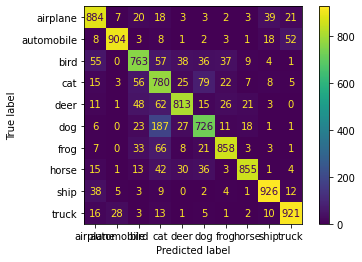

In [ ]:
test_results = one_epoch([student], test_loader, criterion, train=False, set_name='Test', metrics=metrics)
disp = ConfusionMatrixDisplay(test_results.pop('confusion_matrix'), display_labels=label_names)
disp.plot()
test_results

: Validation Loss: 4.739e-01: 100%|██████████| 40/40 [00:22<00:00,  1.80it/s]

Accuracy of Validation set: 0.8489


{'loss': 0.4739305542945862,
 'accuracy': 0.8489,
 'precision': 0.8553733464213356,
 'recall': 0.8480607571601103,
 'f1': 0.8500887591889164}

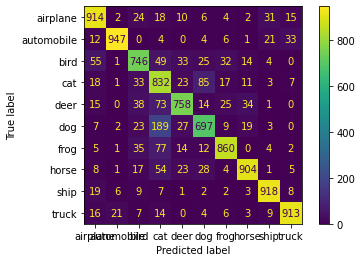

In [ ]:
val_results = one_epoch([student], val_loader, criterion, train=False, set_name='Validation', metrics=metrics)
disp = ConfusionMatrixDisplay(val_results.pop('confusion_matrix'), display_labels=label_names)
disp.plot()
val_results

: Train Loss: 4.306e-02: 100%|██████████| 157/157 [01:29<00:00,  1.76it/s]


Accuracy of Train set: 0.99555


{'loss': 0.043055653762817385,
 'accuracy': 0.99555,
 'precision': 0.9955704120399492,
 'recall': 0.9955670973174433,
 'f1': 0.995554207768131}

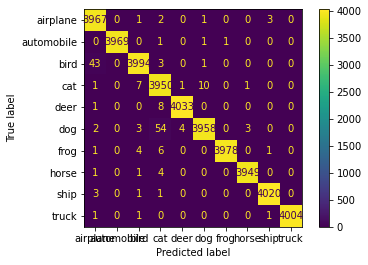

In [ ]:
train_results = one_epoch([student], train_loader, criterion, train=False, set_name='Train', metrics=metrics)
disp = ConfusionMatrixDisplay(train_results.pop('confusion_matrix'), display_labels=label_names)
disp.plot()
train_results

Actually, training student from scratch achieved a better result in contrast to what we expected. It may be because I coudn't search enough for hyperparameters because of GPU shortage.

### Finetuning all layers of teacher:

In [18]:
clear_history()
teacher = get_teacher()

In [19]:
# Training config
lr = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, teacher.parameters()), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, threshold=0.0001, verbose=True)

0: Train Loss: 5.972e-01: 100%|██████████| 313/313 [07:38<00:00,  1.46s/it]


Accuracy of Train set: 0.797825


0: Validation Loss: 5.248e-01: 100%|██████████| 79/79 [00:43<00:00,  1.82it/s]


Accuracy of Validation set: 0.821

 ------------------------------------------------------------


1: Train Loss: 3.891e-01: 100%|██████████| 313/313 [07:50<00:00,  1.50s/it]


Accuracy of Train set: 0.867975


1: Validation Loss: 6.994e-01: 100%|██████████| 79/79 [00:43<00:00,  1.83it/s]


Accuracy of Validation set: 0.7723

 ------------------------------------------------------------


2: Train Loss: 2.948e-01: 100%|██████████| 313/313 [07:50<00:00,  1.50s/it]


Accuracy of Train set: 0.89915


2: Validation Loss: 4.178e-01: 100%|██████████| 79/79 [00:43<00:00,  1.83it/s]


Accuracy of Validation set: 0.8615

 ------------------------------------------------------------


3: Train Loss: 2.288e-01: 100%|██████████| 313/313 [07:50<00:00,  1.50s/it]


Accuracy of Train set: 0.92185


3: Validation Loss: 4.139e-01: 100%|██████████| 79/79 [00:42<00:00,  1.85it/s]


Accuracy of Validation set: 0.8658

 ------------------------------------------------------------


4: Train Loss: 1.811e-01: 100%|██████████| 313/313 [07:49<00:00,  1.50s/it]


Accuracy of Train set: 0.936575


4: Validation Loss: 5.552e-01: 100%|██████████| 79/79 [00:42<00:00,  1.84it/s]


Accuracy of Validation set: 0.8379

 ------------------------------------------------------------


5: Train Loss: 1.436e-01: 100%|██████████| 313/313 [07:49<00:00,  1.50s/it]


Accuracy of Train set: 0.9508


5: Validation Loss: 3.600e-01: 100%|██████████| 79/79 [00:42<00:00,  1.85it/s]


Accuracy of Validation set: 0.8876

 ------------------------------------------------------------


6: Train Loss: 1.270e-01: 100%|██████████| 313/313 [07:49<00:00,  1.50s/it]


Accuracy of Train set: 0.956775


6: Validation Loss: 4.209e-01: 100%|██████████| 79/79 [00:42<00:00,  1.86it/s]

Accuracy of Validation set: 0.8776

 ------------------------------------------------------------


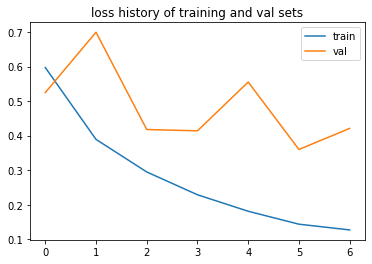

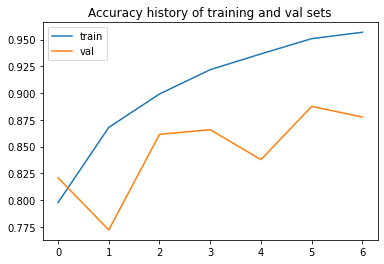

In [21]:
teacher, min_val_loss = train_model([teacher], [train_loader, val_loader], 7, criterion, optimizer, scheduler=scheduler)

: Test Loss: 3.744e-01: 100%|██████████| 79/79 [00:42<00:00,  1.86it/s]

Accuracy of Test set: 0.8877


{'loss': 0.3743671550989151,
 'accuracy': 0.8877,
 'precision': 0.8906904046702383,
 'recall': 0.8876999999999999,
 'f1': 0.8873859557306348}

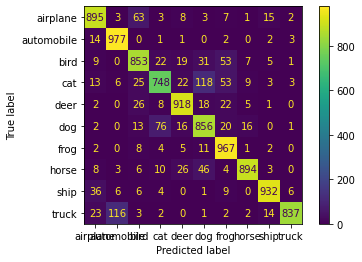

In [22]:
test_results = one_epoch([teacher], test_loader, criterion, train=False, set_name='Test', metrics=metrics)
disp = ConfusionMatrixDisplay(test_results.pop('confusion_matrix'), display_labels=label_names)
disp.plot()
test_results

: Validation Loss: 3.600e-01: 100%|██████████| 79/79 [00:42<00:00,  1.85it/s]

Accuracy of Validation set: 0.8876


{'loss': 0.3599565941810608,
 'accuracy': 0.8876,
 'precision': 0.8899716242862656,
 'recall': 0.8876245272106795,
 'f1': 0.8873197399297093}

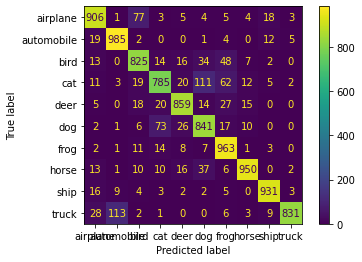

In [23]:
val_results = one_epoch([teacher], val_loader, criterion, train=False, set_name='Validation', metrics=metrics)
disp = ConfusionMatrixDisplay(val_results.pop('confusion_matrix'), display_labels=label_names)
disp.plot()
val_results

As we fine-tuned all layers of the teacher, we can see that it overfits to the training data (and achieves a better test result too).

You can also note how more time consuming it is to train the teacher with all layers fine-tuned due to the long backpropagation chain (more than 7 minutes per epoch).